In [1]:
# importing libraries
import math
import numpy as np
import pandas as pd
import datetime
import scipy.stats as stats
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
import yfinance as yfin     
import random as rand
yfin.pdr_override() # This is crucial to avioid list constraints

In [2]:
# yfin is not an official part of yahoo finance but instead is a open soruce library that makes use of Yahoo's public data. 
# start_date = "2020-01-1"
# end_date = "2020-12-31"
# df1 = pdr.DataReader("META", start = start_date, end= end_date)
# print(df1)

# or we can make use of get_data_yahoo directly.
# df2 = pdr.get_data_yahoo("META", start = start_date, end = end_date)
# print(df2)


# df1 = pdr.get_data_yahoo("META", start = "2022-01-01", end = "2023-01-01")
# return1 = df1.pct_change()
# print(return1)

In [3]:
def get_data(ticker, start, end):
    asset = pdr.get_data_yahoo(ticker, start, end)
    asset = asset['Adj Close']
    returns = asset.pct_change()
    meanReturns = returns.mean()
    covMatrix = returns.cov()
    return meanReturns, covMatrix

In [4]:
# This stock list comprises of major ompanies trading at NSE
tickers = ['HDFCBANK', 'LT', 'INFY']
ticker = [stock + '.NS' for stock in tickers]
end_date = datetime.datetime.now()
start_date = end_date - datetime.timedelta(365)
meanReturns, covMatrix = get_data(ticker, start_date, end_date)
weights = np.random.rand(len(meanReturns))
weights /= np.sum(weights)

[*********************100%%**********************]  3 of 3 completed


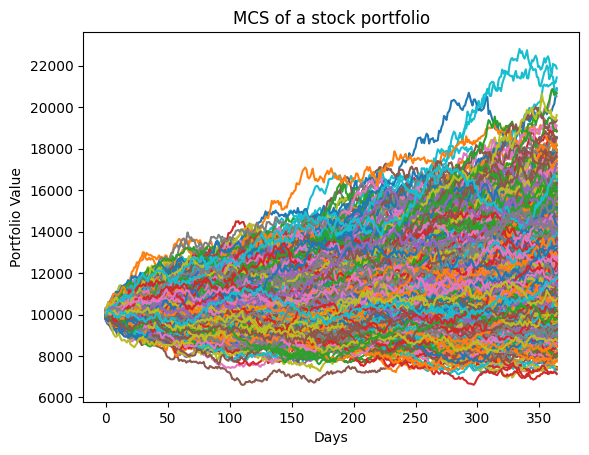

VaR_5 INR 1097.27
CVaR_5 INR 1734.69


In [5]:
# Monte Carlo Simulation 
no_mcs = 1000 # number of simulations
T = 365
meanM = np.full(shape = (T, len(weights)), fill_value = meanReturns)
# print(meanM.shape)
meanM = meanM.T
portfolio_sims = np.full(shape=(T, no_mcs), fill_value = 0.0)
initialPortfolio = 10000
for m in range(0, no_mcs):
    Z = np.random.normal(size=(T, len(weights))) # uncorrelated RV's
    L = np.linalg.cholesky(covMatrix) #Cholesky decomposition to LTM
    dailyReturns = meanM + np.inner(L, Z) # Correlated daily returns for individual stocks
    portfolio_sims[:,m] = np.cumprod(np.inner(weights, dailyReturns.T) + 1) * initialPortfolio # Price today = Price yeasterday * (1 + growth rate)

plt.plot(portfolio_sims)
plt.ylabel('Portfolio Value')
plt.xlabel('Days')
plt.title('MCS of a stock portfolio')
plt.show()
def mcVaR(returns, alpha = 5):
    #input: pandas series of returns, output: percentile on return distribution to a given confidence level alpha

    if isinstance(returns, pd.Series):
        return np.percentile(returns, alpha)
    else:
        raise TypeError('Expected a pandas data series')
def mcCVaR(returns, alpha = 5):
    #input: pandas series of returns, output: CVaR or Expected Shortfall to a given confidence level alpha

    if isinstance(returns, pd.Series):
        belowVaR = returns <= mcVaR(returns, alpha=alpha)
        return returns[belowVaR].mean()
    else:
        raise TypeError('Expected a pandas data series')
        

portResults = pd.Series(portfolio_sims[-1, :])
VaR = initialPortfolio - mcVaR(portResults, alpha = 5)
CVaR = initialPortfolio - mcCVaR(portResults, alpha = 5)
print('VaR_5 INR {}'.format(round(VaR, 2)))
print('CVaR_5 INR {}'.format(round(CVaR, 2)))